In [ ]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy

In [2]:
import numpy as np

fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

In [3]:
# n_components 매개변수에 주성분의 개수 지정
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [4]:
print(pca.components_.shape)

(50, 10000)


In [5]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    # n은 샘플 개수입니다
    # 한 줄에 10개씩 이미지를 그립니다. 샘플 개수를 10으로 나누어 전체 행 개수를 계산합니다. 
    rows = int(np.ceil(n/10))
    # 행이 1개 이면 열 개수는 샘플 개수입니다. 그렇지 않으면 10개입니다.
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:    # n 개까지만 그립니다.
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()

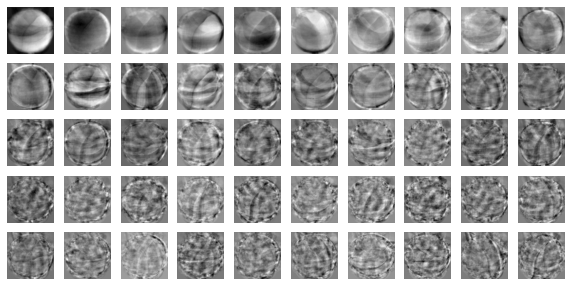

In [6]:
# 주성분을 100 x 100 이미지로 출력
# 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것

draw_fruits(pca.components_.reshape(-1, 100, 100))

In [7]:
# 10000개의 픽셀(특성)을 가진 300개의 이미지
print(fruits_2d.shape)

(300, 10000)


In [8]:
# 50개의 특성을 가진 데이터로 차원축소
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


In [9]:
# 원본 데이터 재구성

fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


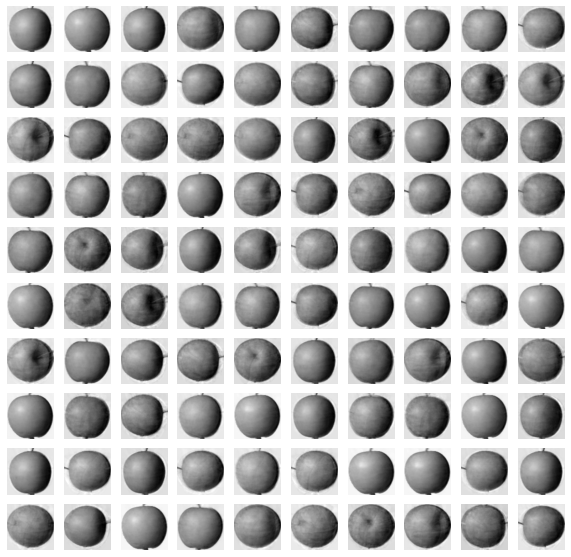

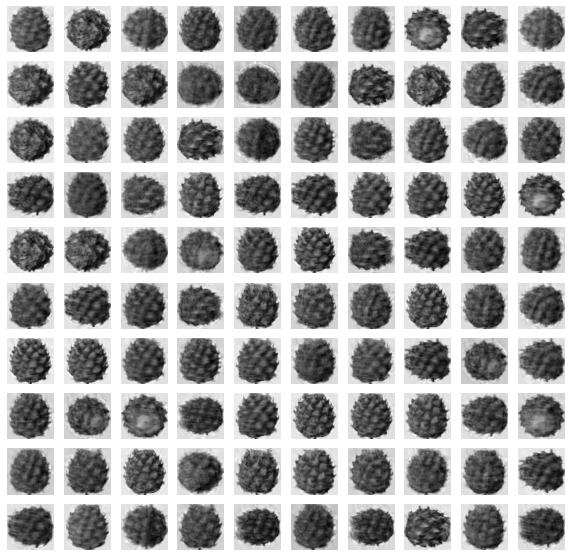

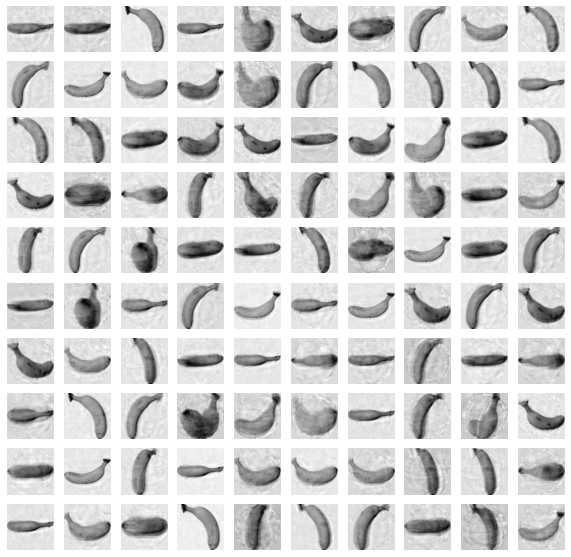

In [10]:
# 100 x 100 크기로 바꾸어 100개씩 나누어 출력

fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

In [11]:
# 주성분이 원본 데이터의 분산을 얼마나 잘 나타내는지 기록한 explained variance (설명된 분산)은 explained_variance_ratio에 있음
print(np.sum(pca.explained_variance_ratio_))

0.9215147059737077


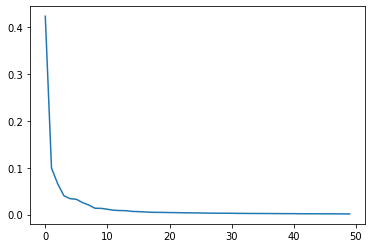

In [12]:
# 처음 10개의 주성분이 대부분의 분산을 표현하고 있음
plt.plot(pca.explained_variance_ratio_)

In [13]:
# 다른 알고리즘과 함께 사용하기
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [14]:
# 100개의 0, 100개의 1, 100개의 2를 가진 타깃 데이터 만들기
target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [15]:
from sklearn.model_selection import cross_validate

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
1.252664566040039


In [16]:
# PCA로 축소한 데이터 사용
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.04446845054626465


In [17]:
# n_components에 설명된 분산의 비율을 입력할 수도 있음, 지정된 비율에 도달할 때까지 자동으로 주성분을 찾음
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [18]:
# 2개의 특성으로 원본 데이터에 있는 분산의 50%를 표현할 수 있음
print(pca.n_components_)

2


In [19]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [20]:
# 2개의 특성만으로 99%의 정확도 달성
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.99
0.03343052864074707


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [21]:
# 차원축소된 데이터로 K-MEANS 알고리즘 클러스터 찾아보기
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

KMeans(n_clusters=3, random_state=42)

In [22]:
print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


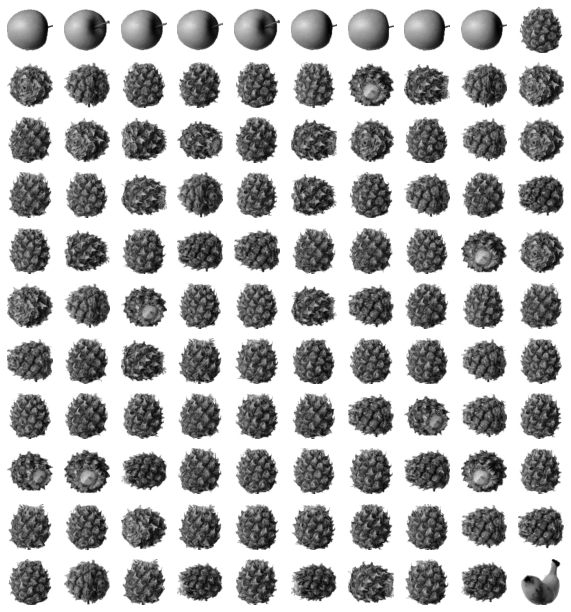

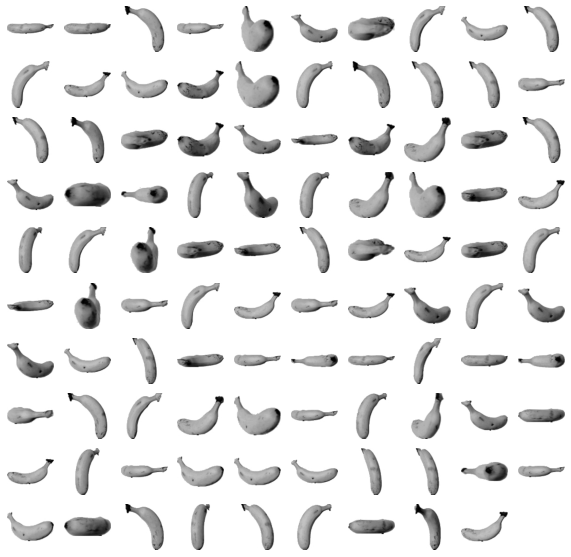

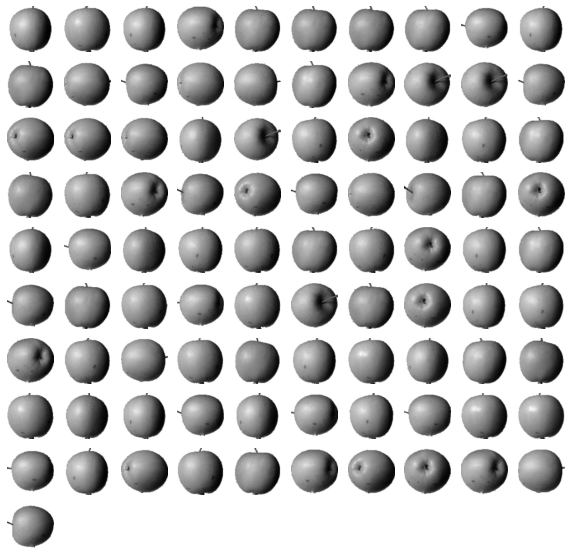

In [23]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

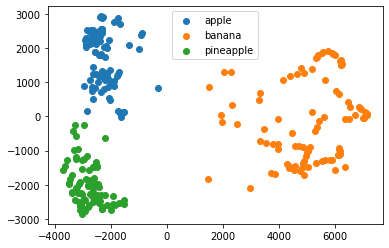

In [24]:
# 3개 이하로 차원을 줄이면 화면에 출력하기 쉬움
# cluster 별로 나누어 산점도 그리기
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()

- 차원 축소: 원본 데이터의 특성을 적은 수의 새로운 특성으로 변환하는 비지도 학습의 한 종류, 저장공간을 줄이고 시각화하기 쉽고 다른 알고리즘의 성능을 높일 수 있음

- PCA(주성분 분석): 차원 축소 알고리즘의 하나로 데이터에서 가장 분산이 큰 방향(주성분)을 찾는 방법, 원본 데이터를 주성분에 투영하여 새로운 특성을 만듦

- explained variance(설명된 분산); 주성분 분석에서 주성분이 얼마나 원본 데이터의 분산을 잘 나타내는지 기록한 것